In [1]:
from Data import *
from NeuralNetwork import *
%load_ext autoreload
%autoreload 2

In [2]:
(train_images, train_labels), (test_images, test_labels)   =  load_data(name = 'fashion_mnist')
train_images, train_labels, valid_images, valid_labels = split_validation(train_images, train_labels, valid_size=0.1, seed = 42)
# train_images, train_labels,_,_ = split_validation(train_images, train_labels, valid_size=0.95, seed = 42)
X_train, X_valid, X_test = preprocess(train_images), preprocess(valid_images), preprocess(test_images)
y_train, y_valid, y_test = one_hot_encoded(train_labels), one_hot_encoded(valid_labels), one_hot_encoded(test_labels)


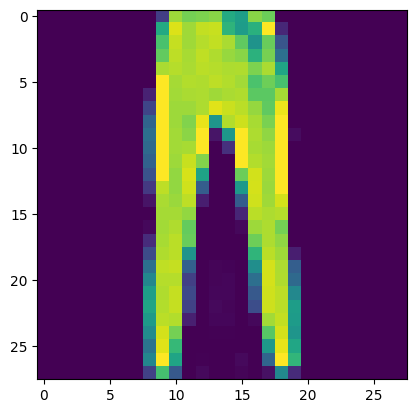

In [3]:
plt.imshow(train_images[10000].reshape(28,28))

In [4]:
fashion_names[train_labels[10000]]

'Trouser'

In [6]:

#Reading the config file

#Getting the configutation from wandb sweep
num_layers = 5
hidden_size = 512
lr = 1e-4
beta = 0.9
beta_m = 0.9
beta_v = 0.99
alpha = 5e-4
winit = "Xavier"
bs = 3000
epochs = 10
optimizer_name = 'nadam'
g_activation = "tanh"


#Preparing hyperparameters for our optimizer
if optimizer_name == 'sgd':
    optim_hp = {'learning_rate':lr, 'alpha': alpha}
elif optimizer_name == 'momentum' or optimizer_name == 'nag' or optimizer_name == 'rmsprop':
    optim_hp = {'learning_rate':lr, 'beta': beta, 'alpha': alpha}
elif optimizer_name == 'adam' or optimizer_name == 'nadam':
    optim_hp = {'learning_rate':lr, 'beta_m': beta_m, 'beta_v': beta_v, 'alpha':alpha}

n_features = X_train.shape[1]
n_classes = y_train.shape[1]
hidden_sizes = [hidden_size]*num_layers + [n_classes]

network_hp = {'batch_size': bs, 'g_activation': ACTIVATIONS_MAP[g_activation]}
mynn = MyNeuralNetwork(n_features, hidden_sizes, n_classes)
mynn.update_network_hp(**network_hp)  
mynn.update_optim_hp(optimizer_name,**optim_hp)   
mynn.params_init(way = winit) 
mynn.train(X_train,y_train,X_valid,y_valid,epochs = epochs)

Epoch 0, T_Loss: 2.390445539382526, T_acc: 0.0627962962962963, V_Loss: 2.387697023290266, V_acc: 0.06966666666666667
Epoch 1, T_Loss: 1.7576540823609412, T_acc: 0.33785185185185185, V_Loss: 1.7537104009743025, V_acc: 0.3403333333333333
Epoch 2, T_Loss: 1.2416359242695687, T_acc: 0.5874074074074074, V_Loss: 1.2391397965247826, V_acc: 0.5908333333333333
Epoch 3, T_Loss: 1.0409103124850168, T_acc: 0.6541666666666667, V_Loss: 1.0413652604698111, V_acc: 0.653
Epoch 4, T_Loss: 0.9227099793389061, T_acc: 0.6855185185185185, V_Loss: 0.9255667797912162, V_acc: 0.6816666666666666
Epoch 5, T_Loss: 0.8584302006595484, T_acc: 0.6979074074074074, V_Loss: 0.8627960140515998, V_acc: 0.695
Epoch 6, T_Loss: 0.8092020999536523, T_acc: 0.7131851851851851, V_Loss: 0.8150853216688638, V_acc: 0.7103333333333334
Epoch 7, T_Loss: 0.7740754626973577, T_acc: 0.7256851851851852, V_Loss: 0.7807937698688677, V_acc: 0.7231666666666666
Epoch 8, T_Loss: 0.7448848589514991, T_acc: 0.7375555555555555, V_Loss: 0.75248175

In [10]:
mynn.train(X_train,y_train,X_valid,y_valid,epochs = 10)

Epoch 0, T_Loss: 0.4643666424487729, T_acc: 0.8345370370370371, V_Loss: 0.47456355929729427, V_acc: 0.8356666666666667
Epoch 1, T_Loss: 0.46212451771507324, T_acc: 0.8351481481481482, V_Loss: 0.47242981219631186, V_acc: 0.8361666666666666
Epoch 2, T_Loss: 0.45993311177421675, T_acc: 0.8357962962962963, V_Loss: 0.4703492204024702, V_acc: 0.8375
Epoch 3, T_Loss: 0.4577903467409759, T_acc: 0.8366666666666667, V_Loss: 0.46831944694072564, V_acc: 0.8385
Epoch 4, T_Loss: 0.4556942960802973, T_acc: 0.8372962962962963, V_Loss: 0.46633832620016014, V_acc: 0.839
Epoch 5, T_Loss: 0.4536431677392823, T_acc: 0.837925925925926, V_Loss: 0.464403846724701, V_acc: 0.8396666666666667
Epoch 6, T_Loss: 0.4516352883733112, T_acc: 0.8385370370370371, V_Loss: 0.4625141343923873, V_acc: 0.8405
Epoch 7, T_Loss: 0.44966908975065856, T_acc: 0.8389444444444445, V_Loss: 0.4606674368241232, V_acc: 0.8403333333333334
Epoch 8, T_Loss: 0.44774309777587107, T_acc: 0.8396851851851852, V_Loss: 0.4588621100536108, V_acc: 

: 

In [25]:
mynn.train(X_train,y_train,X_valid,y_valid,epochs = 10)

Epoch 0, T_Loss: 1.859315632527439, T_acc: 0.23592592592592593, V_Loss: 1.8575566741113119, V_acc: 0.23866666666666667
Epoch 1, T_Loss: 1.9175079987000518, T_acc: 0.22148148148148147, V_Loss: 1.934515260370076, V_acc: 0.21166666666666667
Epoch 2, T_Loss: 1.9771581499629145, T_acc: 0.22111111111111112, V_Loss: 2.0008885753759165, V_acc: 0.21216666666666667
Epoch 3, T_Loss: 1.7317235633765997, T_acc: 0.26407407407407407, V_Loss: 1.742943337378979, V_acc: 0.26316666666666666
Epoch 4, T_Loss: 1.7741181627893656, T_acc: 0.24259259259259258, V_Loss: 1.7785471558641266, V_acc: 0.24266666666666667
Epoch 5, T_Loss: 1.628909223227189, T_acc: 0.2833333333333333, V_Loss: 1.639248265080958, V_acc: 0.281
Epoch 6, T_Loss: 1.8459224000637853, T_acc: 0.20074074074074075, V_Loss: 1.8469254544967248, V_acc: 0.201
Epoch 7, T_Loss: 2.1595353996247275, T_acc: 0.2788888888888889, V_Loss: 2.173633069145296, V_acc: 0.27366666666666667
Epoch 8, T_Loss: 2.224629325845141, T_acc: 0.17222222222222222, V_Loss: 2.26

In [ ]:
y_test_pred = mynn.predict(X_test)

In [ ]:
print(np.sum(np.argmax(y_test,axis = 1)==np.argmax(y_test_pred,axis = 1))/y_test.shape[0])

0.7294


In [ ]:
from collections import Counter
np.unique(np.argmax(y_train,axis = 1), return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([270, 270, 270, 270, 270, 270, 270, 270, 270, 270]))

In [ ]:
mynn.weights[0]

array([[ 0.44397905, -0.2270532 ,  0.85351622, ..., -1.66284238,
         0.06621643,  0.46687932],
       [ 0.55918849,  1.16691805,  0.87170058, ..., -0.33291553,
         0.1899259 ,  0.71354788],
       [-1.5601007 , -0.5778982 ,  0.67630795, ..., -0.57130518,
         0.88317859,  0.44534818],
       ...,
       [-0.53291019, -0.67599409,  1.37280076, ...,  1.81105739,
        -0.12194865,  0.84618229],
       [ 0.82133766,  0.64010845, -0.43371267, ..., -1.92825264,
        -0.22334057, -0.67335536],
       [ 1.76370395, -0.02307934, -0.35251759, ...,  1.24726423,
         1.64829953,  1.31408006]])